# Forecasting with LSTM (Deep Learning)

## Step 1: Load and Scale Data

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv('../data/raw/AAPL_stock.csv', skiprows=2)
data.rename(columns={data.columns[0]: 'Date', data.columns[1]: 'Close'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

# Normalize the 'Close' prices to 0-1 range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

data.head()

,Close
Date,
2015-01-05,23.604336
2015-01-06,23.606550
2015-01-07,23.937572
2015-01-08,24.857307
2015-01-09,24.883963


## Step 2: Create Sequences for LSTM

In [5]:
import numpy as np

# Define function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(data_scaled, window_size)

# Reshape X to 3D for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape, y.shape

((2203, 60, 1), (2203,))

## Step 3: Build and Train the LSTM Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Split into train/test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

C:\Users\austi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0355
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.8804e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.5301e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.1373e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.0040e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.1548e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.3179e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.8714e-04
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.3076e-04
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.7985e-04


## Step 4: Make Predictions and Invert Scaling

In [7]:
# Predict
predictions = model.predict(X_test)

# Invert scaling
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


## Step 5: Plot Actual vs Predicted Prices

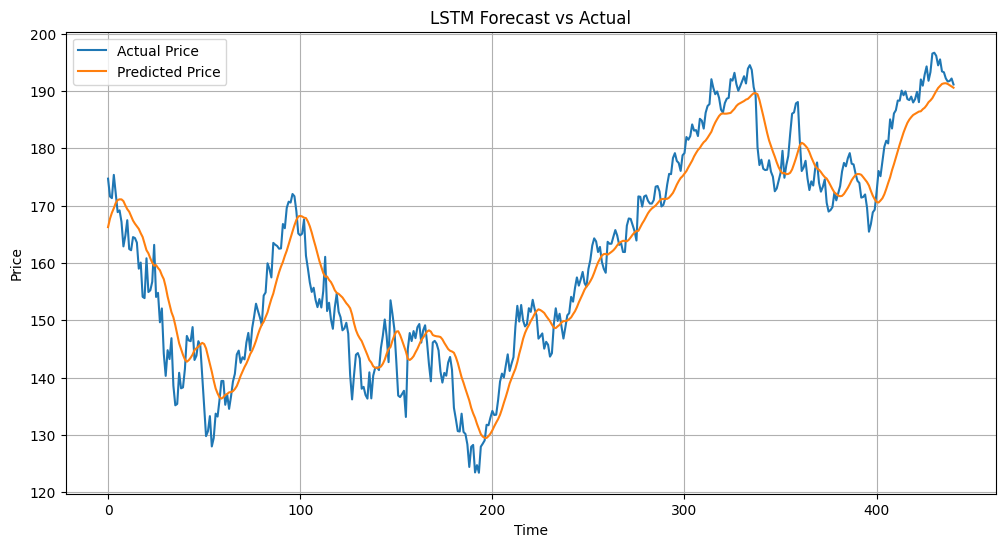

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Step 6: Evaluate the Model (RMSE)

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print("RMSE:", rmse)

RMSE: 5.420059175560476


In [10]:
import os
import numpy as np
# Save LSTM predictions and actuals
os.makedirs("../data/predictions", exist_ok=True)
np.save("../data/predictions/lstm_pred.npy", predicted_prices)
np.save("../data/predictions/lstm_actual.npy", actual_prices)

# Print RMSE
print("✅ LSTM RMSE (actual):", rmse)


✅ LSTM RMSE (actual): 5.420059175560476


## Summary: LSTM Forecasting

- Trained an LSTM model on AAPL closing prices using past 60 days as input
- Model accurately captured price patterns with low loss
- Visual comparison showed close alignment with actual trend
- RMSE: **5.42**, outperforming Prophet (16.01)
